In [96]:
import pandas as pd
import numpy as np
import re
import sys
import nltk
from collections import Counter
import shutil

from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Algumas funções prontas
import funcoes
import modelos
import modelos2

from modelos import *
from modelos2 import *

import importlib
importlib.reload(funcoes)
importlib.reload(modelos)
importlib.reload(modelos2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'modelos2' from '/home/matheus/Documents/Mentoria/Avaliação Final/modelos2.py'>

### Puxando o banco de dados:

In [97]:
df_train = pd.read_csv("train_binary_small.csv")

df_test = pd.read_csv("test_binary_small.csv")
df_test.head()

,id,comment_text,Toxic
0,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",Toxic
1,0013a435effa29bd,"I'd never think I'd need to say it, but Wikipe...",Non-Toxic
2,001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",Toxic
3,008eb47c4684d190,""" \n\n So, on the tenth anniversary of 9/11, ""...",Toxic
4,00991697be5ed76a,Simple: You are stupid!,Toxic


### **Pré-processamento:**

In [98]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1500 non-null   object
 1   comment_text  1500 non-null   object
 2   Toxic         1500 non-null   object
dtypes: object(3)
memory usage: 35.3+ KB


In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2000 non-null   object
 1   comment_text  2000 non-null   object
 2   Toxic         2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


#### Verificando valores nulos:

In [100]:
df_test.isnull().sum()

id              0
comment_text    0
Toxic           0
dtype: int64

In [101]:
df_train.isnull().sum()

id              0
comment_text    0
Toxic           0
dtype: int64

#### Como o Dataset está dividido:

In [102]:
df_train["Toxic"].value_counts()

Toxic        1500
Non-Toxic     500
Name: Toxic, dtype: int64

#### Dropando a coluna id:

In [103]:
df_train.drop("id", axis=1, inplace=True)

df_test.drop("id", axis=1, inplace=True)
df_test.head()

,comment_text,Toxic
0,"== Arabs are committing genocide in Iraq, but ...",Toxic
1,"I'd never think I'd need to say it, but Wikipe...",Non-Toxic
2,"::No, he is an arrogant, self serving, immatur...",Toxic
3,""" \n\n So, on the tenth anniversary of 9/11, ""...",Toxic
4,Simple: You are stupid!,Toxic


### Substituindo valores Toxic por 1 e Non-Toxic por 0

In [104]:
df_train['Toxic'] = np.where(df_train['Toxic'] == 'Toxic', 1, 0)

df_test['Toxic'] = np.where(df_test['Toxic'] == 'Toxic', 1, 0)
df_test.head()

,comment_text,Toxic
0,"== Arabs are committing genocide in Iraq, but ...",1
1,"I'd never think I'd need to say it, but Wikipe...",0
2,"::No, he is an arrogant, self serving, immatur...",1
3,""" \n\n So, on the tenth anniversary of 9/11, ""...",1
4,Simple: You are stupid!,1


### Removendo duplicados:

In [105]:
df_train.drop_duplicates(["comment_text"], inplace = True)
df_test.drop_duplicates(["comment_text"], inplace = True)

### Limpando o dataset:
- Limpando todos os caracteres que não são letras nem números
- Removendo link
- Deixando minúsculo

In [106]:
link_and_users = funcoes.Link()

In [107]:
df_train["limpeza_simples"] = df_train['comment_text'].apply(lambda x: re.sub(r'\W+',' ', x))
df_train["limpeza_simples"] = df_train["limpeza_simples"].apply(lambda x: link_and_users.re_links_and_users(x))
df_train["limpeza_simples"] = df_train["limpeza_simples"].str.lower()

In [108]:
df_test["limpeza_simples"] = df_test['comment_text'].apply(lambda x: re.sub(r'\W+',' ', x))
df_test["limpeza_simples"] = df_test["limpeza_simples"].apply(lambda x: link_and_users.re_links_and_users(x))
df_test["limpeza_simples"] = df_test["limpeza_simples"].str.lower()

# EDA:


### Às palavras mais frequentes:

In [109]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

<AxesSubplot:xlabel='Word', ylabel='Frequency'>

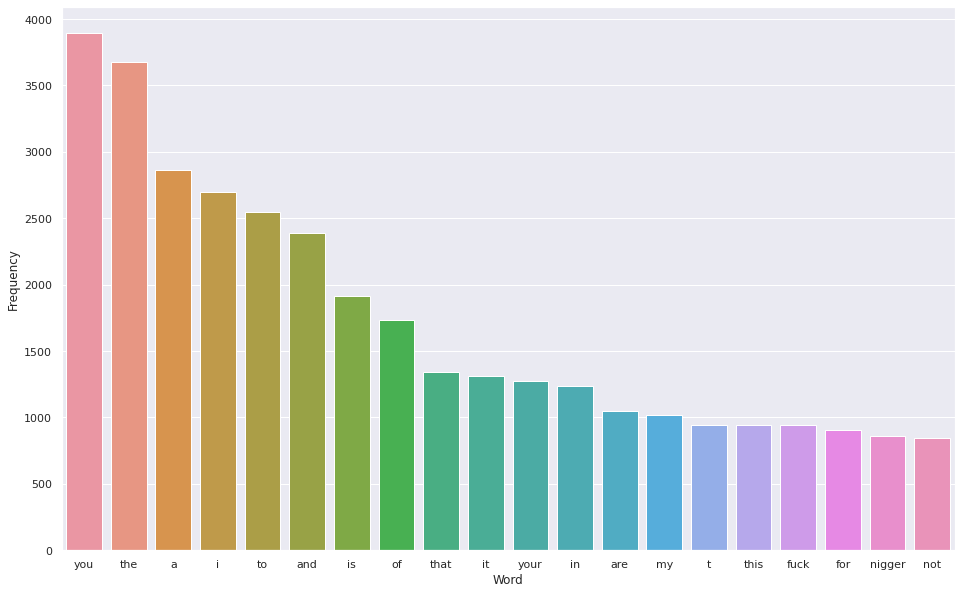

In [110]:
corpus = df_train_copy['limpeza_simples'].tolist()
word_count = Counter(" ".join(corpus).split()).most_common(20)
word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
sns.set(rc={"figure.figsize": (16,10)})
sns.barplot(x="Word", y="Frequency", data=word_frequency)

- Como se é esperado as palavras que mais se repetem são as stopwords

### Remoção de stopwords:

In [111]:
stop = funcoes.Stopword()
df_train_copy["limpeza_simples_stopwords"] = df_train_copy['limpeza_simples'].apply(lambda x: stop.re_stopword(x))
df_test_copy["limpeza_simples_stopwords"] = df_test_copy['limpeza_simples'].apply(lambda x: stop.re_stopword(x))

<AxesSubplot:xlabel='Word', ylabel='Frequency'>

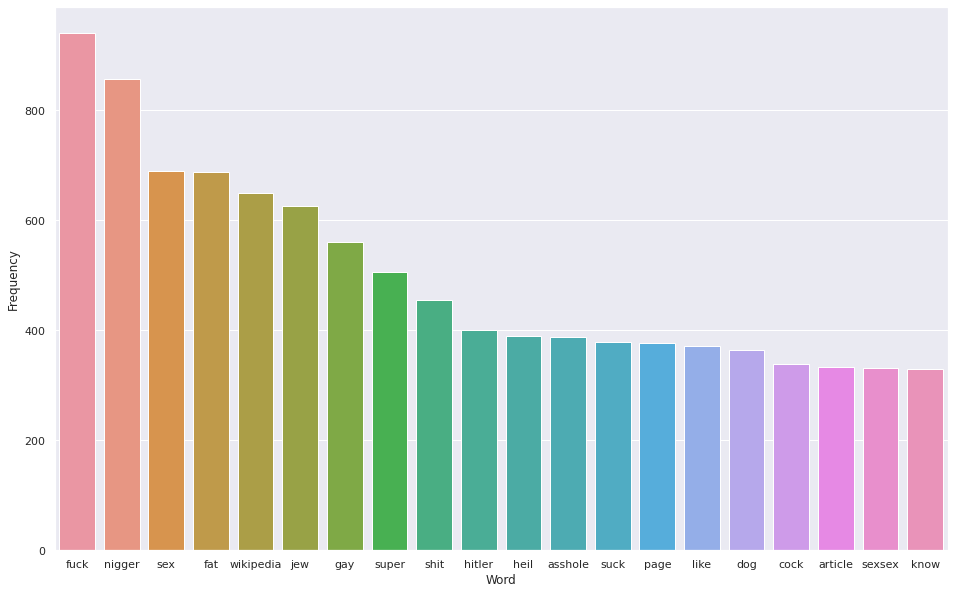

In [112]:
corpus = df_train_copy['limpeza_simples_stopwords'].tolist()
word_count = Counter(" ".join(corpus).split()).most_common(20)
word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
sns.barplot(x="Word", y="Frequency", data=word_frequency)

- Agora temos uma melhor visão do dataset e pode se observar que temos algumas palavras como "sexsex" que poderia ser substituída por "sex" com regex, trabalhando logo abaixo exemplos como esse.

### Remover letras únicas e remover algumas palavras manualmente:

In [113]:
sub_re = funcoes.Sub_re()
one_word = funcoes.One_carct()

In [114]:
df_train_copy["limpeza_simples"] = df_train_copy['limpeza_simples'].apply(lambda x: sub_re.sub_re(x))
df_train_copy["limpeza_simples"] = df_train_copy['limpeza_simples'].apply(lambda x: one_word.words_one(x))

df_train_copy["limpeza_simples_stopwords"] = df_train_copy['limpeza_simples_stopwords'].apply(lambda x: sub_re.sub_re(x))
df_train_copy["limpeza_simples_stopwords"] = df_train_copy['limpeza_simples_stopwords'].apply(lambda x: one_word.words_one(x))

In [115]:
df_test_copy["limpeza_simples"] = df_test_copy['limpeza_simples'].apply(lambda x: sub_re.sub_re(x))
df_test_copy["limpeza_simples"] = df_test_copy['limpeza_simples'].apply(lambda x: one_word.words_one(x))

df_test_copy["limpeza_simples_stopwords"] = df_test_copy['limpeza_simples_stopwords'].apply(lambda x: sub_re.sub_re(x))
df_test_copy["limpeza_simples_stopwords"] = df_test_copy['limpeza_simples_stopwords'].apply(lambda x: one_word.words_one(x))

# WORD CLOUD:

In [116]:
corpus = df_train_copy['limpeza_simples_stopwords'].tolist()
corpus_all = " ".join(corpus)

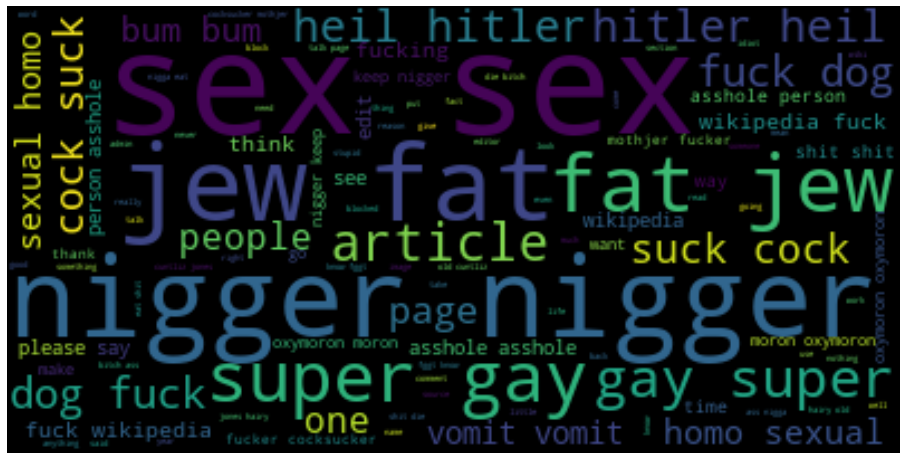

In [117]:
wordcloud = WordCloud().generate(corpus_all)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# WORD CLOUD TOXIC

In [118]:
corpus = df_train_copy[df_train_copy['Toxic']==1]['limpeza_simples_stopwords'].tolist()
corpus_all = " ".join(corpus)

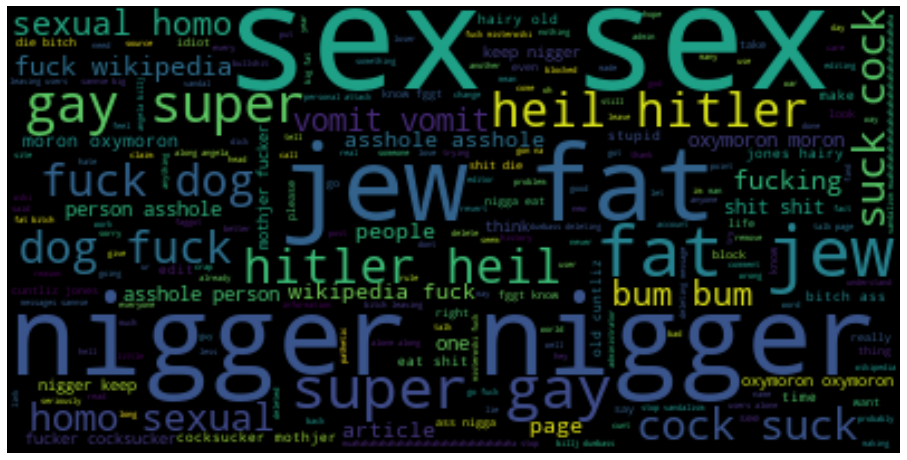

In [119]:
wordcloud = WordCloud().generate(corpus_all)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Utilizando a nuvem de palavras para ter uma melhor visão das palavras tóxicas.
- Pode se observar bem definido palavras: sex, nigger, fat, jew fuck...

# WORD CLOUD NON-TOXIC

In [120]:
corpus = df_train_copy[df_train_copy['Toxic']==0]['limpeza_simples_stopwords'].tolist()
corpus_all = " ".join(corpus)

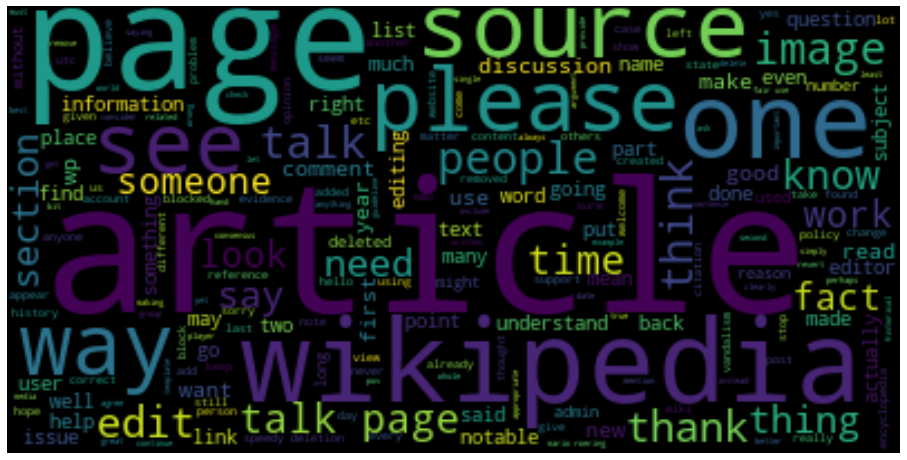

In [121]:
wordcloud = WordCloud().generate(corpus_all)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Pode se observar que tem palavras bem divididar na nuvem de palavras, porem tem algumas palavras que se repetem nós dois.

# Adicionando alguns pré processamento:

In [122]:
lem = funcoes.Lematization()
stem = funcoes.Stemming()

In [123]:
# Limpeza simples, stopwords, lematização
df_train_copy["limpeza_simples_stopwords_lem"] = df_train_copy['limpeza_simples_stopwords'].apply(lambda x: lem.lemmatization(x))

# Limpeza simples, stopwords, stemming
df_train_copy["limpeza_simples_stopwords_stem"] = df_train_copy['limpeza_simples_stopwords'].apply(lambda x: stem.stemming(x))

# Limpeza simples, stopwords, lematização, stemming
df_train_copy["limpeza_simples_stopwords_lem_stem"] = df_train_copy['limpeza_simples_stopwords_lem'].apply(lambda x: stem.stemming(x))

# Limpeza simples, lematização
df_train_copy["limpeza_simples_lem"] = df_train_copy['limpeza_simples'].apply(lambda x: lem.lemmatization(x))

# Limpeza simples, stemming
df_train_copy["limpeza_simples_stem"] = df_train_copy['limpeza_simples'].apply(lambda x: stem.stemming(x))

# Limpeza simples, lematização, stemming
df_train_copy["limpeza_simples_lem_stem"] = df_train_copy['limpeza_simples_lem'].apply(lambda x: stem.stemming(x))

In [124]:
# Limpeza simples, stopwords, lematização
df_test_copy["limpeza_simples_stopwords_lem"] = df_test_copy['limpeza_simples_stopwords'].apply(lambda x: lem.lemmatization(x))

# Limpeza simples, stopwords, stemming
df_test_copy["limpeza_simples_stopwords_stem"] = df_test_copy['limpeza_simples_stopwords'].apply(lambda x: stem.stemming(x))

# Limpeza simples, stopwords, lematização, stemming
df_test_copy["limpeza_simples_stopwords_lem_stem"] = df_test_copy['limpeza_simples_stopwords_lem'].apply(lambda x: stem.stemming(x))

# Limpeza simples, lematização
df_test_copy["limpeza_simples_lem"] = df_test_copy['limpeza_simples'].apply(lambda x: lem.lemmatization(x))

# Limpeza simples, stemming
df_test_copy["limpeza_simples_stem"] = df_test_copy['limpeza_simples'].apply(lambda x: stem.stemming(x))

# Limpeza simples, lematização, stemming
df_test_copy["limpeza_simples_lem_stem"] = df_test_copy['limpeza_simples_lem'].apply(lambda x: stem.stemming(x))

In [125]:
df_train_copy.head()

,comment_text,Toxic,limpeza_simples,limpeza_simples_stopwords,limpeza_simples_stopwords_lem,limpeza_simples_stopwords_stem,limpeza_simples_stopwords_lem_stem,limpeza_simples_lem,limpeza_simples_stem,limpeza_simples_lem_stem
0,All of my edits are good. Cunts like you who ...,1,all of my edits are good cunts like you who re...,edits good cunts like revert good edits stupid...,edit good cunt like revert good edit stupid un...,edit good cunt like revert good edit stupid un...,edit good cunt like revert good edit stupid un...,all of my edit be good cunt like you who rever...,all of my edit are good cunt like you who reve...,all of my edit be good cunt like you who rever...
1,you are a stupid fuck \n\nand your mother's cu...,1,you are stupid fuck and your mother cunt stinks,stupid fuck mother cunt stinks,stupid fuck mother cunt stink,stupid fuck mother cunt stink,stupid fuck mother cunt stink,you be stupid fuck and your mother cunt stink,you are stupid fuck and your mother cunt stink,you be stupid fuck and your mother cunt stink
2,"""\n\nAnd you are? Let me know when you've craw...",1,and you are let me know when you ve crawled ou...,let know crawled arses dick laurent dead,let know crawl arsis dick laurent dead,let know crawl ars dick laurent dead,let know crawl arsi dick laurent dead,and you be let I know when you ve crawl out of...,and you are let me know when you ve crawl out ...,and you be let i know when you ve crawl out of...
3,Fuck off\n\nYou are NOT an administrator. You ...,1,fuck off you are not an administrator you don ...,fuck administrator authority tell,fuck administrator authority tell,fuck administr author tell,fuck administr author tell,fuck off you be not an administrator you don h...,fuck off you are not an administr you don have...,fuck off you be not an administr you don have ...
4,"Have you seen the reference to their claim, yo...",1,have you seen the reference to their claim you...,seen reference claim moron source pov time red...,see reference claim moron source pov time redu...,seen refer claim moron sourc pov time reduc pa...,see refer claim moron sourc pov time reduc pas...,have you see the reference to their claim you ...,have you seen the refer to their claim you mor...,have you see the refer to their claim you moro...


In [126]:
list_preprocessing =[
    'limpeza_simples',
    'limpeza_simples_lem', 
    'limpeza_simples_stem',
    'limpeza_simples_lem_stem', 
    'limpeza_simples_stopwords',
    'limpeza_simples_stopwords_lem', 
    'limpeza_simples_stopwords_stem', 
    'limpeza_simples_stopwords_lem_stem',
    ]

## TREINO:

In [127]:
cv = 2
all_scores = {}

for vectorizer_name,vectorizer in VECTORIZERS.items():

    for model_name, model in CLF_MODELS.items():
        pipeline = Pipeline([("vect", vectorizer), ("clf", model)])

        model_params = {}

        for param_name, parameters in VECTORIZERS_PARAMS.items():
                new_name = 'vect__'+param_name
                model_params[new_name] = parameters

        for step in list_preprocessing:
            X_train = df_train_copy[step].values.astype('U')
            y_train = df_train_copy['Toxic'].to_list()

            X_test = df_test_copy[step].values.astype('U')
            y_test = df_test_copy['Toxic'].to_list()

            approach_name = (f"{step}__{model_name}__{vectorizer_name}")
            
            rs = RandomizedSearchCV(
                    pipeline, model_params, random_state=42, cv=cv, n_jobs=2,)
        
            rs.fit(X_train, y_train)
            
            print(f'[INFO] {approach_name}')
            print(rs.best_score_)

            dst_file = f'/home/matheus/Documents/Mentoria/Avaliação Final/lista_param/{approach_name}.pkl'
            joblib.dump(rs,dst_file)

            y_pred = rs.predict(X_test)

            scores = {
                'accuracy':accuracy_score(y_test, y_pred),
                'f1':f1_score(y_test, y_pred),
                'confusion_matrix':confusion_matrix(y_test, y_pred),
                'best_param':rs.best_params_,
            }

            all_scores.update({approach_name:{'scores':scores}})

[INFO] limpeza_simples__Bayes__TFIDF
0.7505
[INFO] limpeza_simples_lem__Bayes__TFIDF
0.7525
[INFO] limpeza_simples_stem__Bayes__TFIDF
0.752
[INFO] limpeza_simples_lem_stem__Bayes__TFIDF
0.7525
[INFO] limpeza_simples_stopwords__Bayes__TFIDF
0.7515000000000001
[INFO] limpeza_simples_stopwords_lem__Bayes__TFIDF
0.753
[INFO] limpeza_simples_stopwords_stem__Bayes__TFIDF
0.754
[INFO] limpeza_simples_stopwords_lem_stem__Bayes__TFIDF
0.754
[INFO] limpeza_simples__KNN__TFIDF
0.7975000000000001
[INFO] limpeza_simples_lem__KNN__TFIDF
0.791
[INFO] limpeza_simples_stem__KNN__TFIDF
0.7955000000000001
[INFO] limpeza_simples_lem_stem__KNN__TFIDF
0.791
[INFO] limpeza_simples_stopwords__KNN__TFIDF
0.791
[INFO] limpeza_simples_stopwords_lem__KNN__TFIDF
0.795
[INFO] limpeza_simples_stopwords_stem__KNN__TFIDF
0.794
[INFO] limpeza_simples_stopwords_lem_stem__KNN__TFIDF
0.789
[INFO] limpeza_simples__SVM_Linear__TFIDF
0.8554999999999999
[INFO] limpeza_simples_lem__SVM_Linear__TFIDF
0.8525
[INFO] limpeza_simpl

/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] limpeza_simples_lem__Logistic_Regression__BOW
0.8345


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] limpeza_simples_stem__Logistic_Regression__BOW
0.835


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] limpeza_simples_lem_stem__Logistic_Regression__BOW
0.835
[INFO] limpeza_simples_stopwords__Logistic_Regression__BOW
0.8285
[INFO] limpeza_simples_stopwords_lem__Logistic_Regression__BOW
0.826
[INFO] limpeza_simples_stopwords_stem__Logistic_Regression__BOW
0.83
[INFO] limpeza_simples_stopwords_lem_stem__Logistic_Regression__BOW
0.833


## Criar o dataset de score:

In [128]:
approach_names = []
accuracies = []
f1_scores = []
best_param = []
for approach_name, score in all_scores.items():
    approach_names.append(approach_name)
    accuracies.append(score["scores"]["accuracy"])
    f1_scores.append(score["scores"]["f1"])
    best_param.append(score['scores']['best_param'])

In [129]:
data = {
    "approach_name":approach_names,
    "accuracy": accuracies,
    "f1": f1_scores,
    "best_param": best_param,
}

In [130]:
df_scores = pd.DataFrame(data)
df_scores.to_csv('data_resultado.csv',index=False)

In [131]:
df_scores.style.background_gradient()

,approach_name,accuracy,f1,best_param
0,limpeza_simples__Bayes__TFIDF,0.672667,0.802890,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.2}"
1,limpeza_simples_lem__Bayes__TFIDF,0.674000,0.803536,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.2}"
2,limpeza_simples_stem__Bayes__TFIDF,0.674000,0.803536,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.2}"
3,limpeza_simples_lem_stem__Bayes__TFIDF,0.674667,0.803859,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.2}"
4,limpeza_simples_stopwords__Bayes__TFIDF,0.674667,0.803859,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.9}"
5,limpeza_simples_stopwords_lem__Bayes__TFIDF,0.676667,0.804829,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.9}"
6,limpeza_simples_stopwords_stem__Bayes__TFIDF,0.678667,0.805802,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.9}"
7,limpeza_simples_stopwords_lem_stem__Bayes__TFIDF,0.679333,0.806127,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.9}"
8,limpeza_simples__KNN__TFIDF,0.752667,0.839602,"{'vect__ngram_range': (1, 2), 'vect__max_df': 0.2}"
9,limpeza_simples_lem__KNN__TFIDF,0.734667,0.830926,"{'vect__ngram_range': (1, 1), 'vect__max_df': 0.2}"


In [132]:
df_sorted = df_scores.sort_values(by = ['accuracy'],ascending = False)
best_five_approaches = df_sorted[:5]['approach_name'].to_list()

In [133]:
df_sorted[:10]


,approach_name,accuracy,f1,best_param
59,limpeza_simples_lem_stem__Bayes__BOW,0.846667,0.892423,"{'vect__ngram_range': (1, 2), 'vect__max_df': ..."
58,limpeza_simples_stem__Bayes__BOW,0.845333,0.891080,"{'vect__ngram_range': (1, 2), 'vect__max_df': ..."
57,limpeza_simples_lem__Bayes__BOW,0.844000,0.890654,"{'vect__ngram_range': (1, 2), 'vect__max_df': ..."
60,limpeza_simples_stopwords__Bayes__BOW,0.828667,0.881839,"{'vect__ngram_range': (1, 2), 'vect__max_df': ..."
18,limpeza_simples_stem__SVM_Linear__TFIDF,0.826667,0.880295,"{'vect__ngram_range': (1, 1), 'vect__max_df': ..."
62,limpeza_simples_stopwords_stem__Bayes__BOW,0.824667,0.880834,"{'vect__ngram_range': (1, 3), 'vect__max_df': ..."
63,limpeza_simples_stopwords_lem_stem__Bayes__BOW,0.824667,0.880834,"{'vect__ngram_range': (1, 3), 'vect__max_df': ..."
19,limpeza_simples_lem_stem__SVM_Linear__TFIDF,0.824000,0.878788,"{'vect__ngram_range': (1, 1), 'vect__max_df': ..."
17,limpeza_simples_lem__SVM_Linear__TFIDF,0.824000,0.879231,"{'vect__ngram_range': (1, 1), 'vect__max_df': ..."
61,limpeza_simples_stopwords_lem__Bayes__BOW,0.823333,0.879709,"{'vect__ngram_range': (1, 3), 'vect__max_df': ..."


## Treino:
- Rodando os melhores modelos do primeiro treino, aumentando os parâmetros.

In [134]:
cv = 2
all_scores2 = {}

for vectorizer_name,vectorizer in VECTORIZERS2.items():

    for model_name, model in CLF_MODELS2.items():
        pipeline = Pipeline([("vect", vectorizer), ("clf", model)])

        model_params2 = {}

        for param_name, parameters in VECTORIZERS_PARAMS2.items():
                new_name = 'vect__'+param_name
                model_params2[new_name] = parameters

        for step in list_preprocessing:
            X_train = df_train_copy[step].values.astype('U')
            y_train = df_train_copy['Toxic'].to_list()

            X_test = df_test_copy[step].values.astype('U')
            y_test = df_test_copy['Toxic'].to_list()

            approach_name2 = (f"{step}__{model_name}__{vectorizer_name}")
            
            rs = RandomizedSearchCV(
                    pipeline, model_params2, random_state=42, cv=cv, n_jobs=2,)
        
            rs.fit(X_train, y_train)
            
            print(f'[INFO] {approach_name2}')
            print("ACC: ",rs.best_score_)

            dst_file2 = f'/home/matheus/Documents/Mentoria/Avaliação Final/lista_param/{approach_name2}.pkl'

            joblib.dump(rs,dst_file2)

            y_pred = rs.predict(X_test)

            scores = {
                'accuracy':accuracy_score(y_test, y_pred),
                'f1':f1_score(y_test, y_pred),
                'confusion_matrix':confusion_matrix(y_test, y_pred),
            }

            all_scores2.update({approach_name2:{'scores':scores}})

/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__Bayes__TFIDF
ACC:  0.7505


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__Bayes__TFIDF
ACC:  0.7525


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__Bayes__TFIDF
ACC:  0.752


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__Bayes__TFIDF
ACC:  0.7525


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__Bayes__TFIDF
ACC:  0.7515000000000001


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__Bayes__TFIDF
ACC:  0.753


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__Bayes__TFIDF
ACC:  0.754


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__Bayes__TFIDF
ACC:  0.754


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__SVM_Linear__TFIDF
ACC:  0.8554999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__SVM_Linear__TFIDF
ACC:  0.8525


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__SVM_Linear__TFIDF
ACC:  0.855


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__SVM_Linear__TFIDF
ACC:  0.854


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__SVM_Linear__TFIDF
ACC:  0.832


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__SVM_Linear__TFIDF
ACC:  0.834


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__SVM_Linear__TFIDF
ACC:  0.8354999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__SVM_Linear__TFIDF
ACC:  0.839


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__MLP_1Layer__TFIDF
ACC:  0.8485


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__MLP_1Layer__TFIDF
ACC:  0.854


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__MLP_1Layer__TFIDF
ACC:  0.845


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__MLP_1Layer__TFIDF
ACC:  0.84


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__MLP_1Layer__TFIDF
ACC:  0.8354999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__MLP_1Layer__TFIDF
ACC:  0.83


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__MLP_1Layer__TFIDF
ACC:  0.8325


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__MLP_1Layer__TFIDF
ACC:  0.839


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__Bayes__BOW
ACC:  0.852


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__Bayes__BOW
ACC:  0.847


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__Bayes__BOW
ACC:  0.8425


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__Bayes__BOW
ACC:  0.842


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__Bayes__BOW
ACC:  0.841


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__Bayes__BOW
ACC:  0.835


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__Bayes__BOW
ACC:  0.828


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__Bayes__BOW
ACC:  0.824


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__SVM_Linear__BOW
ACC:  0.817


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__SVM_Linear__BOW
ACC:  0.825


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__SVM_Linear__BOW
ACC:  0.8160000000000001


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__SVM_Linear__BOW
ACC:  0.8205


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__SVM_Linear__BOW
ACC:  0.81


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__SVM_Linear__BOW
ACC:  0.8125


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__SVM_Linear__BOW
ACC:  0.8109999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__SVM_Linear__BOW
ACC:  0.81


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples__MLP_1Layer__BOW
ACC:  0.8505


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem__MLP_1Layer__BOW
ACC:  0.847


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stem__MLP_1Layer__BOW
ACC:  0.854


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_lem_stem__MLP_1Layer__BOW
ACC:  0.8414999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords__MLP_1Layer__BOW
ACC:  0.833


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem__MLP_1Layer__BOW
ACC:  0.8325


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_stem__MLP_1Layer__BOW
ACC:  0.8294999999999999


/home/matheus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[INFO] limpeza_simples_stopwords_lem_stem__MLP_1Layer__BOW
ACC:  0.836


In [135]:
approach_names = []
accuracies = []
f1_scores = []
best_param = []
for approach_name, score in all_scores2.items():
    approach_names.append(approach_name)
    accuracies.append(score["scores"]["accuracy"])
    f1_scores.append(score["scores"]["f1"])
    

In [136]:
data2 = {
    "approach_name":approach_names,
    "accuracy": accuracies,
    "f1": f1_scores,
}

In [137]:
df_scores2 = pd.DataFrame(data2)
df_scores2.to_csv('data_resultado2.csv',index=False)

In [138]:
df_scores2.style.background_gradient()

,approach_name,accuracy,f1
0,limpeza_simples__Bayes__TFIDF,0.672667,0.802890
1,limpeza_simples_lem__Bayes__TFIDF,0.674000,0.803536
2,limpeza_simples_stem__Bayes__TFIDF,0.674000,0.803536
3,limpeza_simples_lem_stem__Bayes__TFIDF,0.674667,0.803859
4,limpeza_simples_stopwords__Bayes__TFIDF,0.674667,0.803859
5,limpeza_simples_stopwords_lem__Bayes__TFIDF,0.676667,0.804829
6,limpeza_simples_stopwords_stem__Bayes__TFIDF,0.678667,0.805802
7,limpeza_simples_stopwords_lem_stem__Bayes__TFIDF,0.679333,0.806127
8,limpeza_simples__SVM_Linear__TFIDF,0.822000,0.877354
9,limpeza_simples_lem__SVM_Linear__TFIDF,0.824000,0.879231


In [139]:
df_sorted2 = df_scores2.sort_values(by = ['accuracy'],ascending = False)
best_five_approaches = df_sorted2[:5]['approach_name'].to_list()

In [140]:
df_sorted2[:10]

,approach_name,accuracy,f1
26,limpeza_simples_stem__Bayes__BOW,0.851333,0.889985
30,limpeza_simples_stopwords_stem__Bayes__BOW,0.850667,0.891262
29,limpeza_simples_stopwords_lem__Bayes__BOW,0.850000,0.891357
31,limpeza_simples_stopwords_lem_stem__Bayes__BOW,0.848667,0.890073
28,limpeza_simples_stopwords__Bayes__BOW,0.846667,0.889635
27,limpeza_simples_lem_stem__Bayes__BOW,0.846000,0.886709
25,limpeza_simples_lem__Bayes__BOW,0.844667,0.885952
24,limpeza_simples__Bayes__BOW,0.842667,0.884427
10,limpeza_simples_stem__SVM_Linear__TFIDF,0.826667,0.880295
42,limpeza_simples_stem__MLP_1Layer__BOW,0.825333,0.878253


limpeza_simples_stem__Bayes__BOW


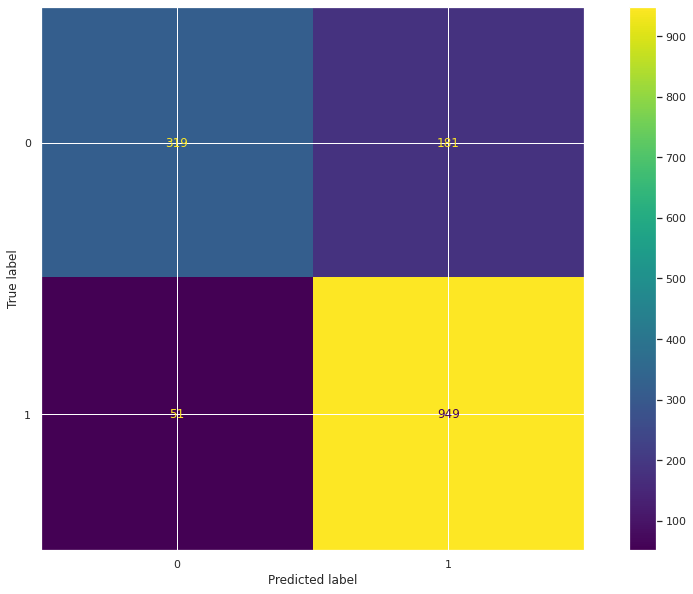

-----------------------------------------------------------------------------------
limpeza_simples_stopwords_stem__Bayes__BOW


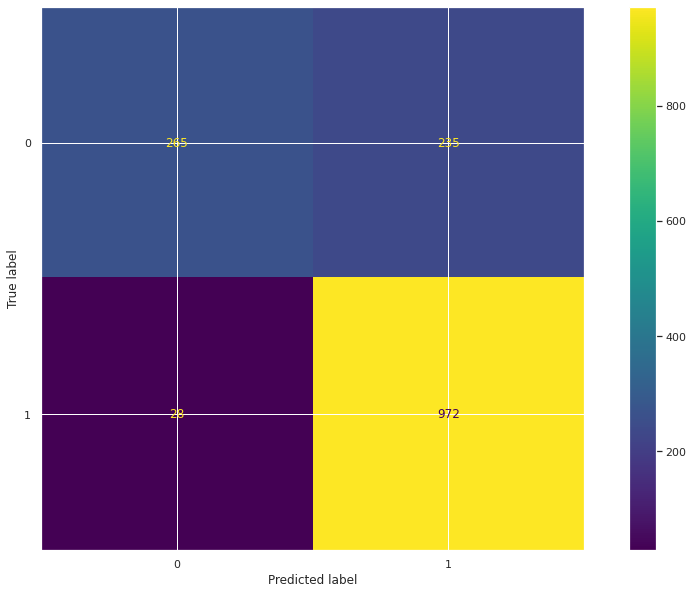

-----------------------------------------------------------------------------------
limpeza_simples_stopwords_lem__Bayes__BOW


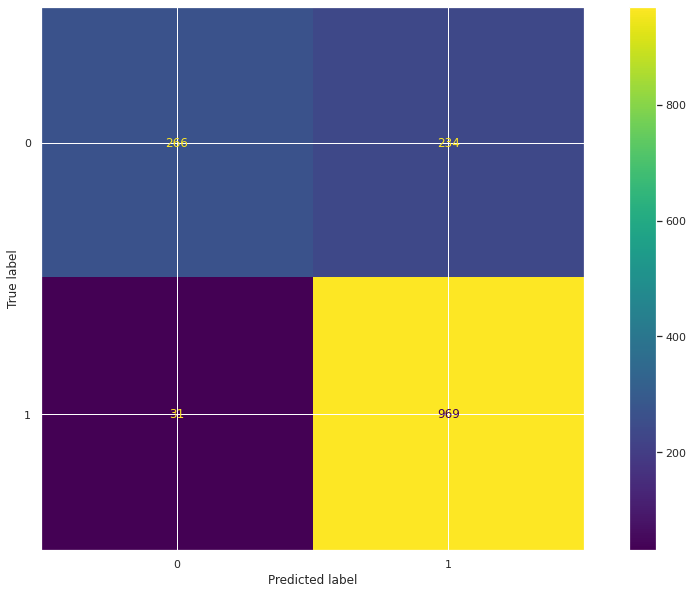

-----------------------------------------------------------------------------------
limpeza_simples_stopwords_lem_stem__Bayes__BOW


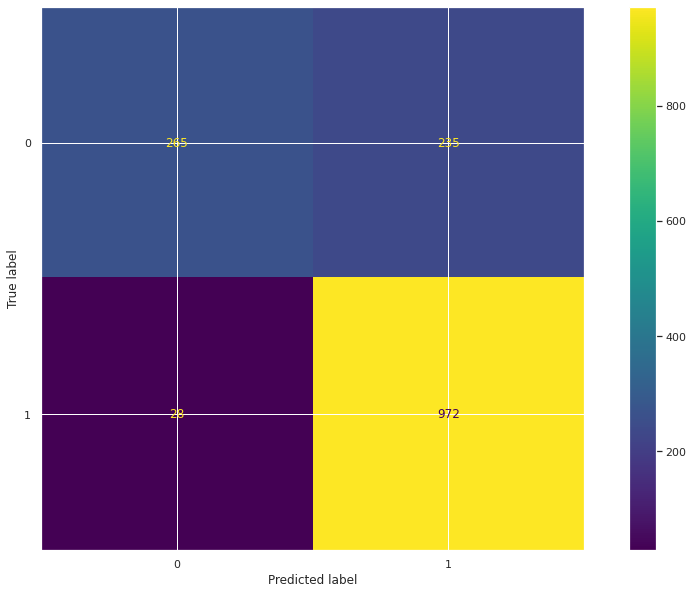

-----------------------------------------------------------------------------------
limpeza_simples_stopwords__Bayes__BOW


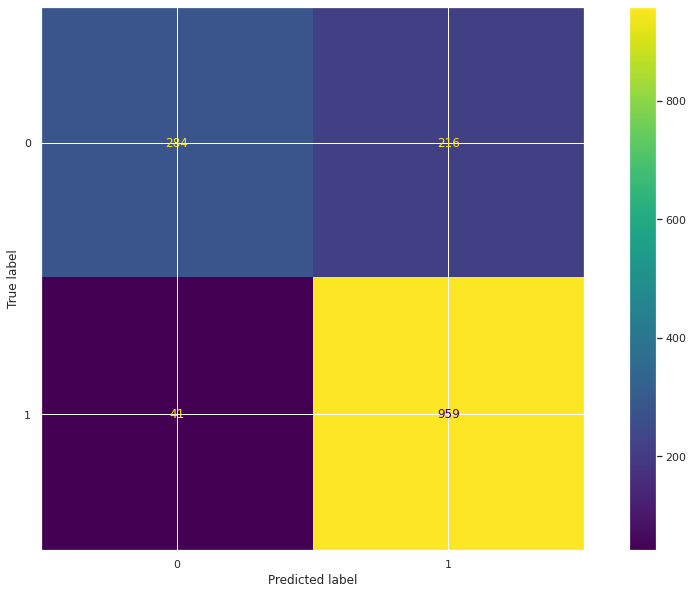

-----------------------------------------------------------------------------------


In [141]:
cms = {}
labels = {
    '0':'Non-Toxic',
    '1':'Toxic'
}
for approach in best_five_approaches:
    cms[approach] = all_scores[approach]['scores']['confusion_matrix']
    print(approach)
    disp = ConfusionMatrixDisplay(confusion_matrix=cms[approach],display_labels=labels)
    disp.plot()
    plt.show()
    print('-'*83)


In [142]:
best_model = 'limpeza_simples_stem__Bayes__BOW'

- O melhor modelo foi utilizar limpeza simples, stemming no Naive Bayer utilizando o BOW
- Pode se observar que em todas as matriz de confusão acima se destaca o erro de classificar os não tóxicos como tóxico, isso pode está ocorrendo porque como foi visto na nuvem de palavras, algumas palavras se repetem nós dois casos, tanto no tóxico, como não tóxico


### Mandar o melhor modelo para a pasta do backend

In [145]:
mdl = f'/home/matheus/Documents/Mentoria/Avaliação Final/lista_param/{best_model}.pkl'
dst = f'/home/matheus/Documents/Mentoria/Avaliação Final/Melhor_modelo/best_modelo.pkl'

In [146]:
shutil.copy2(mdl,dst)

'/home/matheus/Documents/Mentoria/Avaliação Final/Melhor_modelo/best_modelo.pkl'